In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Observed data 

In [25]:
stations = pd.read_parquet('../results/reporting_points/reporting_points_over_500km2.parquet')
stations = stations[['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country']]
stations.head()

name          X          Y     area  \
id                                                            
1               Schwabelweis  4477500.0  2882500.0  35525.0   
2                 Hofkirchen  4547500.0  2847500.0  47525.0   
3                   Pfelling  4517500.0  2867500.0  37725.0   
4                      Barby  4452500.0  3207500.0  93975.0   
5   Wittenberg / Lutherstadt  4497500.0  3197500.0  61675.0   

         subcatchment   river catchment country  
id                                               
1              Danube  Danube    Danube      DE  
2              Danube  Danube    Danube      DE  
3              Danube  Danube    Danube      DE  
4   Elbe, below Saale    Elbe      Elbe      DE  
5                Elbe    Elbe      Elbe      DE

In [26]:
stations.to_csv('../results/reporting_points/reporting_points_over_500km2.csv')

In [2]:
stations = pd.read_csv('../data/discharge/observed/6hourData.csv', index_col='station_id')

In [3]:
data = pd.read_csv('../data/discharge/observed/output-6h-nrt-operational.txt', index_col='Station ID', na_values=[-9999, -999, -99])
data.Timestamp = pd.to_datetime(data.Timestamp)

In [13]:
stns = data.index.unique().tolist()
stns.sort()
dates = pd.date_range(datetime(2018, 1, 1), data.Timestamp.max() + timedelta(hours=1), freq='6h')
obs = pd.DataFrame(index=dates, columns=stns, dtype=float)
for i, stn in enumerate(stns):
    
    print(f'{i+1:02d} from {len(stns):02d}', end='\r')
    
    aux = data.loc[stn, ['Timestamp', 'AvgValue']]
    aux.set_index('Timestamp', drop=True, inplace=True)
    aux = aux.loc['2018-01-01':, 'AvgValue']
    aux[(aux < 0) | (aux > 10000)] = np.nan
    obs.loc[aux.index, stn] = aux.values

## Reanalysis data

In [6]:
def KGE(observado, simulado, sa=1, sb=1, sr=1):
    """Calcula el coeficiente de eficiencia de Kling-Gupta.
    
    Parámetros:
    -----------
    observado:   series. Serie observada
    simulado:    series. Serie simulada
    sa, sb, sr: integer. Factores de escala de los tres términos del KGE: alpha, beta y coeficiente de correlación, respectivamente
    
    Salida:
    -------
    KGE:        float. Eficienica de Kling-Gupta"""
    
    # Eliminar pasos sin dato
    data = pd.concat((observado, simulado), axis=1)
    data.columns = ['obs', 'sim']
    data.dropna(axis=0, how='any', inplace=True)
    # Para la función si no hay datos
    if data.shape[0] == 0:
        return

    # calcular cada uno de los términos del KGE
    alpha = data.sim.std() / data.obs.std()
    beta = data.sim.mean() / data.obs.mean()
    r = np.corrcoef(data.obs, data.sim)[0, 1]
    
    # Cacular KGE
    ED = np.sqrt((sr * (r - 1))**2 + (sa * (alpha - 1))**2 + (sb * (beta - 1))**2)
    KGE = 1 - ED
    
    return KGE

In [15]:
rea = pd.DataFrame(dtype=float)
files = glob.glob('../data/discharge/reanalysis/*.csv')
for file in files:
    aux = pd.read_csv(file, parse_dates=True, index_col=0)
    aux.columns = aux.columns.astype(int)
    rea = pd.concat((rea, aux), axis=0)

## Comparison

In [8]:
# cut series so that they have the same extent
start = max(obs.index.min(), rea.index.min())
end = min(obs.index.max(), rea.index.max())
obs = obs.loc[start:end,:]
rea = rea.loc[start:end,:]

In [9]:
kge = pd.Series(index=stns, dtype=float)
for stn in stns:
    kge[stn] = KGE(obs[stn], rea[stn])

In [10]:
kge.sort_values()

968    -3.436861
1281   -0.387989
1140    0.208123
606     0.216671
1076    0.241898
1048    0.284587
1020    0.287224
1082    0.359251
136     0.375601
1107    0.385396
1026    0.415423
1036    0.416172
1110    0.424264
1141    0.471373
26      0.487261
870     0.489061
1040    0.490725
1263    0.493988
1068    0.518509
1083    0.548672
1132    0.558133
1077    0.580610
1088    0.598616
1114    0.611008
1056    0.619308
1037    0.622514
1131    0.631329
142     0.632886
323     0.657919
1103    0.658761
19      0.668787
1119    0.678481
1101    0.683321
132     0.706199
1181    0.727229
1086    0.738451
1075    0.754684
1041    0.756734
1099    0.757605
1017    0.778312
1060    0.805553
366     0.806714
830     0.821280
393     0.853351
953     0.889151
153     0.897011
dtype: float64

In [11]:
stn = kge.idxmin()
print(stn)

968


KeyError: '2996'

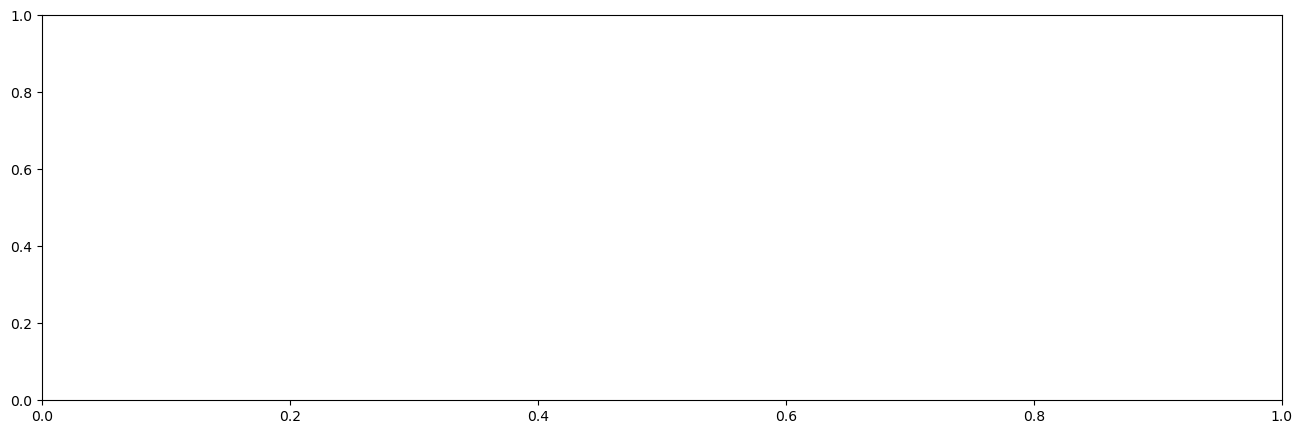

In [12]:
stn = '2996'

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(obs.index, obs[stn], label='obs')
ax.plot(rea.index, rea[stn], label='sim')
ax.legend();

stations.loc[stn]

In [ ]:
rea.plot(figsize=(16, 5));